## Test Binary (Men's vs Women's) Model Accuracy
#### Also test whether similar watch recommendations are better (or worse)

In [2]:
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image

from sklearn.metrics.pairwise import cosine_similarity
from keras.models import load_model, Model

%matplotlib inline

Using TensorFlow backend.


__Load Models__

In [3]:

watch_model = load_model('inceptionv3_binary_unfrozen_convos1_final.h5') 

In [4]:
watch_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, None, None, 2048)  21802784  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 11,116,929
Non-trainable params: 10,687,904
_________________________________________________________________


In [202]:
layer_name = 'avg_pool'
watch_model_headless = Model(inputs=watch_model.input,
                                 outputs=watch_model.get_layer(layer_name).output)

In [203]:
watch_df = pd.read_csv('all_watch_info_with_indicators.csv')

In [204]:

def prepare_image(image_name):
    im_watch = Image.open(image_name)
    im_watch = im_watch.resize((299,299))
    im_watch_array = np.array(im_watch)
    im_watch_array = np.expand_dims(im_watch_array, axis=0)
    return im_watch_array

In [205]:
f_path = 'all_pics/'
f_list = os.listdir(f_path)

__Test Recommendations__

In [206]:
good_files = []
for filename in glob.iglob('multi_class_testing/**/**/*.jpg', recursive=True):
    good_files.append(filename)

In [207]:
good_files = list(set(good_files))

Make Feature Vectors

In [115]:
if 'inceptionv3_binary_feature_vectors.npy' not in os.listdir():
    fvec_dict = dict()

    for ix, g_f in enumerate(good_files):
        img = prepare_image(g_f)/255
        k = g_f.split('/')[-1].split('_')[-1].split('.')[0]
        v = watch_model_headless.predict(img)
        fvec_dict[k] = v
        
        if ix % 50 == 0:
            print(ix)

    #Make Lists of file names and feature vectors
    watch_names = []
    fvec_list = []
    for k, v in fvec_dict.items():
        watch_names.append(k)
        fvec_list.append(v[0])

    #Save Files
    # Numeric Features
    fvecs = np.asarray(fvec_list)
    np.save('inceptionv3_binary_feature_vectors.npy',fvecs)
    
    # File Names
    watch_names = pd.DataFrame(watch_names,columns=['file_name'])
    watch_names.to_csv(
        'inceptionv3_binary_watch_names.csv',index = False)
    
else:
    fvecs = np.load('inceptionv3_binary_feature_vectors.npy')
    watch_names = pd.read_csv('inceptionv3_binary_watch_names.csv',index_col=0)
    watch_names.reset_index(inplace=True)
    
    

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
10050
10100
10150

In [211]:
np.shape(fvecs)

(10449, 2048)

__Compute Cosine Similarities__

In [212]:
dists = cosine_similarity(fvecs) 

In [213]:
np.shape(dists)

(10449, 10449)

In [214]:
dist_df = pd.DataFrame(data = dists)

In [215]:
dist_df.index = watch_names['file_name'].iloc[:]
dist_df.columns = watch_names['file_name'].iloc[:]

Function for finding n closest matches

In [216]:
def get_similar(watchs, n=None):
    """
    calculates which watchs are most similar to the watchs provided. Does not return
    the watchs that were provided
    
    Parameters
    ----------
    watchs: list
        some watchs!
    
    Returns
    -------
    ranked_watchs: list
        rank ordered watchs
    """
    watchs = [watch for watch in watchs if watch in dist_df.columns]
    watchs_summed = dist_df[watchs].apply(lambda row: np.sum(row), axis=1)
    watchs_summed = watchs_summed.sort_values(ascending=False)
    ranked_watchs = watchs_summed.index[watchs_summed.index.isin(watchs)==False]
    ranked_watchs = ranked_watchs.tolist()
    if n is None:
        return ranked_watchs
        
    else:
        return ranked_watchs[:n]

Random Image from Watch store Database

__ Get Recommendations__

In [217]:
good_files = []
for filename in glob.iglob('binary_gender_masked/**/**/*.jpg', recursive=True):
    good_files.append(filename)

In [218]:
# f_path = 'all_pics/'
# f_list = os.listdir(f_path)

(-0.5, 245.5, 399.5, -0.5)

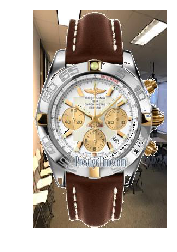

In [224]:
starting_name = np.random.choice(good_files)
img=mpimg.imread(starting_name)
imgplot = plt.imshow(img)
plt.axis('off')

In [225]:
n = 6

In [233]:
img = prepare_image(starting_name)
img = img/255

In [234]:
out = watch_model_headless.predict(img)
similarities = cosine_similarity(out,fvecs) 
top_matches = np.array(similarities).argpartition(-n)[0][-n:]

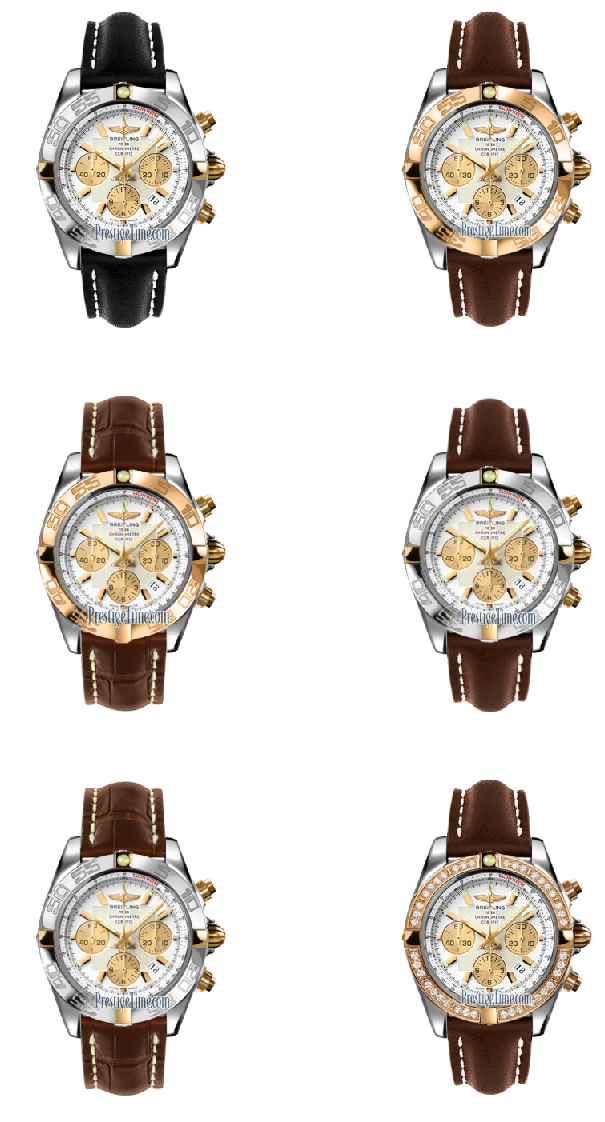

In [235]:
recommend_names = dist_df.columns[top_matches]

r = int(np.ceil(n/2))
c = 2
plt.subplots(nrows=r, ncols=c,figsize=(12,20))

for ix, f_name in enumerate(recommend_names):
    plt.subplot(r,c,ix+1)
    img_rec=mpimg.imread(f_path + f_name + '.jpg')
    imgplot = plt.imshow(img_rec)
    plt.axis('off')

Predict Intended Gender

In [236]:
starting_name_short = starting_name.split('_')[-1].split('/')[-1][:-4]

In [237]:
watch_df.loc[
    watch_df['image_name'] ==starting_name_short][['image_name','is_male']]

,image_name,is_male
6486,BreitlingChronomat44IB011012a6962lt,1


In [238]:
np.shape(img)

(1, 299, 299, 3)

In [239]:
out = watch_model.predict(img)
out

array([[ 0.99999273]], dtype=float32)

__ Open Random Pictures and Test Classification__

(-0.5, 1399.5, 1049.5, -0.5)

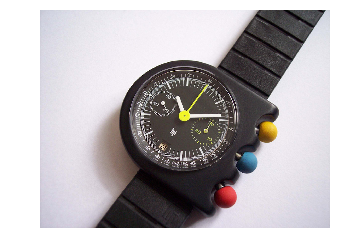

In [417]:
test_path = 'test_pics/'
test_files = os.listdir(test_path)

test_file = test_path + np.random.choice(test_files)
#test_file = test_path + 'blogger-image--2007922873.jpg' #
#test_file = test_path +'Bulgari-Octo-Finissimo-Automatic-Thinnest-Titanium-Sand-Blasted-2017-aBlogtoWatch-22.jpg'
#test_file = test_path +'cocktail_watch.JPG'
#test_file = test_path +'james_bonds_wrist.png'
#test_file = test_path +'ga054-omega-seamaster-planet-ocean-skyfall.jpg'

img2show=mpimg.imread(test_file)
imgplot = plt.imshow(img2show)
plt.axis('off')

In [418]:
img = prepare_image(test_file)
img = img/255
out = watch_model.predict(img)
print(out)

[[ 0.97685802]]


In [419]:
out = watch_model_headless.predict(img)
similarities = cosine_similarity(out,fvecs) 
top_matches = np.array(similarities).argpartition(-n)[0][-n:]

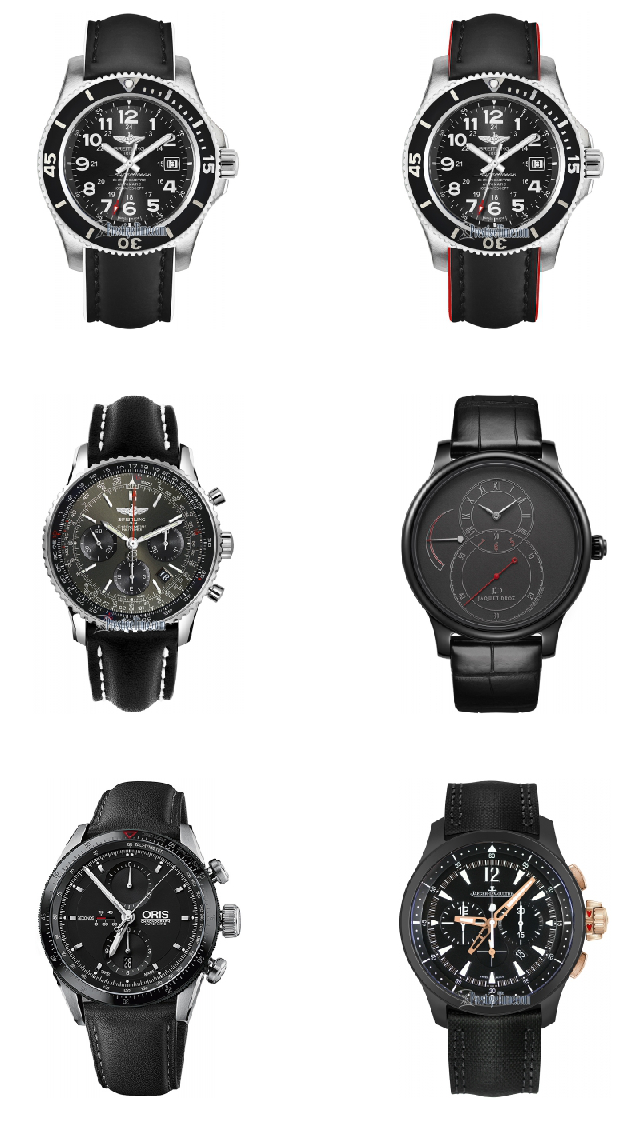

In [420]:
recommend_names = dist_df.columns[top_matches]

r = int(np.ceil(n/2))
c = 2
plt.subplots(nrows=r, ncols=c,figsize=(12,20))

for ix, f_name in enumerate(recommend_names):
    plt.subplot(r,c,ix+1)
    img_rec =mpimg.imread(f_path + f_name + '.jpg')
    imgplot = plt.imshow(img_rec)
    plt.axis('off')